In [1]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random


Segmentation Models: using `keras` framework.


This code is loading and processing image and mask files for semantic segmentation. It visualizes specific channels of an image and identifies unique pixel values and their counts in a mask image, which is crucial for analyzing the labels in semantic segmentation tasks.

Labels are:  [  0   1   2 255]  and the counts are:  [ 886573 1260042  578583   17138]


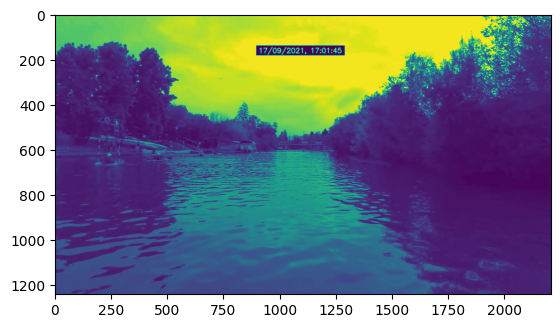

In [2]:
temp_img = cv2.imread(r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\train\images\davimar_seq_07_00848.jpg") #3 channels / spectral bands
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\dataset\train\semantic_masks\davimar_seq_07_00848.png") #3 channels but all same. 
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)


In [3]:
# Define separate paths for images and masks
img_dir = r'C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\train\images'  # Path to the images folder
mask_dir = r'C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\dataset\train\semantic_masks'  # Path to the masks folder

patch_size = 256

# Function to patch images and masks
def patch_images_and_masks(img_dir, mask_dir):
    # Process Images
    for path, subdirs, files in os.walk(img_dir):
        dirname = path.split(os.path.sep)[-1]
        images = os.listdir(path)  # List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".tif"):
                image = cv2.imread(os.path.join(path, image_name), 1)  # Read each image as BGR
                SIZE_X = (image.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0] // patch_size) * patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
                image = np.array(image)
                
                # Extract patches from each image
                print(f"Now patchifying image: {os.path.join(path, image_name)}")
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                # Save patches
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i, j, :, :]
                        cv2.imwrite(os.path.join(img_dir, "256_patches/images/", f"{image_name}_patch_{i}_{j}.tif"), single_patch_img)

    # Process Masks
    for path, subdirs, files in os.walk(mask_dir):
        dirname = path.split(os.path.sep)[-1]
        masks = os.listdir(path)  # List of all mask names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".tif"):
                mask = cv2.imread(os.path.join(path, mask_name), 0)  # Read each mask as grayscale
                SIZE_X = (mask.shape[1] // patch_size) * patch_size
                SIZE_Y = (mask.shape[0] // patch_size) * patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
                mask = np.array(mask)
                
                # Extract patches from each mask
                print(f"Now patchifying mask: {os.path.join(path, mask_name)}")
                patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)
                
                # Save patches
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i, j, :, :]
                        cv2.imwrite(os.path.join(mask_dir, "256_patches/masks/", f"{mask_name}_patch_{i}_{j}.tif"), single_patch_mask)


# Run the function to patch images and masks
patch_images_and_masks(img_dir, mask_dir)




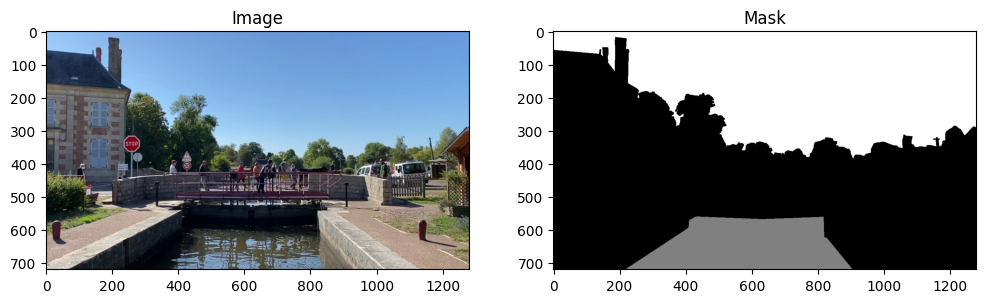

In [4]:
# Load a random image and mask for visualization
train_img_dir = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\train\images"
train_mask_dir = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\dataset\train\semantic_masks"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(img_list)
img_num = random.randint(0, num_images - 1)

img_for_plot = cv2.imread(os.path.join(train_img_dir, img_list[img_num]), 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot = cv2.imread(os.path.join(train_mask_dir, msk_list[img_num]), 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [5]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Selected image: C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\train\images\orca_usv_inland_N02_4_01279.jpg
Selected mask: C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\dataset\train\semantic_masks\orca_usv_inland_N02_4_01279.png


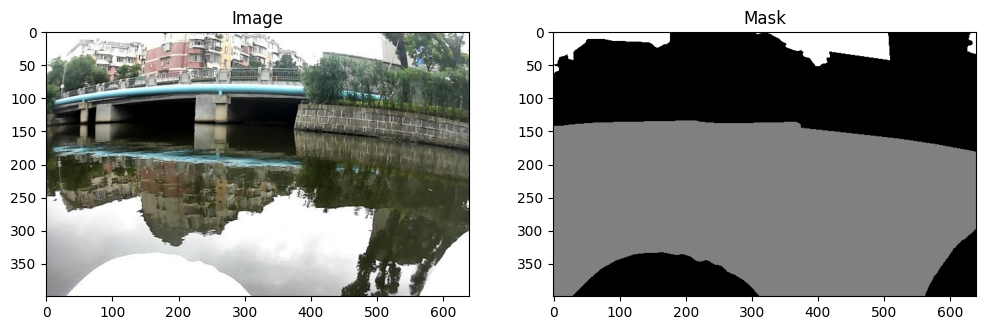

In [6]:
import os
import cv2
import random
import matplotlib.pyplot as plt

train_img_dir = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\train\images"
train_mask_dir = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\dataset\train\semantic_masks"

# List files with valid extensions
img_list = [f for f in os.listdir(train_img_dir) if f.endswith(('.tif', '.jpg', '.png'))]
msk_list = [f for f in os.listdir(train_mask_dir) if f.endswith(('.tif', '.jpg', '.png'))]

# Check if lists are not empty
if not img_list or not msk_list:
    print("Image or mask directory is empty!")
else:
    num_images = len(img_list)
    img_num = random.randint(0, num_images-1)

    # Print selected files for debugging
    img_path = os.path.join(train_img_dir, img_list[img_num])
    mask_path = os.path.join(train_mask_dir, msk_list[img_num])
    print(f"Selected image: {img_path}")
    print(f"Selected mask: {mask_path}")

    # Read and process image and mask
    img_for_plot = cv2.imread(img_path, 1)
    mask_for_plot = cv2.imread(mask_path, 0)

    # Check if files were loaded correctly
    if img_for_plot is None:
        print(f"Failed to load image: {img_path}")
    elif mask_for_plot is None:
        print(f"Failed to load mask: {mask_path}")
    else:
        # Convert image to RGB and plot
        img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 8))
        plt.subplot(121)
        plt.imshow(img_for_plot)
        plt.title('Image')
        plt.subplot(122)
        plt.imshow(mask_for_plot, cmap='gray')
        plt.title('Mask')
        plt.show()


(16, 256, 256, 3) (16, 256, 256, 4)


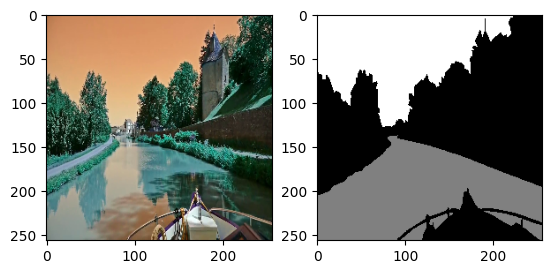

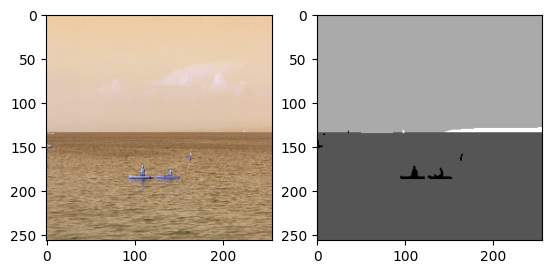

In [7]:
import numpy as np
import os
import cv2
from keras.utils import to_categorical
import segmentation_models as sm
import matplotlib.pyplot as plt

# Set parameters
seed = 24
batch_size = 16
n_classes = 4
IMG_HEIGHT = 256  # Target image height
IMG_WIDTH = 256  # Target image width
IMG_CHANNELS = 3  # Image channels (RGB)

# Preprocessing for ResNet34 (check compatibility with MinMaxScaler)
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Function to perform additional preprocessing after data augmentation
def preprocess_data(img, mask, num_class, target_size=(256, 256)):
    # Resize images and masks to target size (e.g., 256x256)
    img = cv2.resize(img, target_size)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)  # Use nearest for masks to avoid interpolation of mask labels
    
    # Scale images (normalized between 0 and 1)
    img = img.astype('float32') / 255.0
    
    # Apply preprocessing for ResNet34 (or other backbone)
    img = preprocess_input(img)  # Assuming you have a preprocessing function for the backbone model
    
    # Ensure mask values are within the valid range (e.g., 0-3 for 4 classes)
    mask = np.clip(mask, 0, num_class - 1)  # Mask values should be between 0 and 3 (4 classes)
    
    # Convert the mask to one-hot encoding (shape becomes (height, width, num_classes))
    mask = to_categorical(mask, num_class)
    
    return img, mask

# Function to load and preprocess images and masks
def load_images_and_masks(img_dir, mask_dir, batch_size, num_class):
    img_list = os.listdir(img_dir)
    mask_list = os.listdir(mask_dir)

    while True:
        # Randomly shuffle image-mask pairs
        indices = np.random.permutation(len(img_list))
        img_list_shuffled = [img_list[i] for i in indices]
        mask_list_shuffled = [mask_list[i] for i in indices]
        
        # Create empty lists for images and masks in this batch
        batch_images = []
        batch_masks = []
        
        # Process each image-mask pair
        for i in range(batch_size):
            img_name = img_list_shuffled[i]
            mask_name = mask_list_shuffled[i]
            
            # Load image and mask
            img = cv2.imread(os.path.join(img_dir, img_name))
            mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)  # Grayscale for masks
            
            # Preprocess image and mask
            img, mask = preprocess_data(img, mask, num_class)
            
            batch_images.append(img)
            batch_masks.append(mask)
        
        # Convert lists to arrays for batching
        yield np.array(batch_images), np.array(batch_masks)

# File paths for training and validation data
train_img_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\train\images"
train_mask_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\dataset\train\semantic_masks"

val_img_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\val\images"
val_mask_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\dataset\val\semantic_masks"

# Create train and validation generators
train_img_gen = load_images_and_masks(train_img_path, train_mask_path, batch_size, n_classes)
val_img_gen = load_images_and_masks(val_img_path, val_mask_path, batch_size, n_classes)

# Verify generator (fetch one batch)
x, y = next(train_img_gen)
print(x.shape, y.shape)  # Should print (batch_size, height, width, 3) for x and (batch_size, height, width, n_classes) for y

# Visualizing the first batch from training data
for i in range(0, 1):  # Visualize only first image-mask pair in batch
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.show()

# Visualizing the first batch from validation data
x_val, y_val = next(val_img_gen)
for i in range(0, 1):  # Visualize only first image-mask pair in batch
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,589 (93.29 MB)

 Trainable params: 24,439,239 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

Epoch 1/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 801s 5s/step - accuracy: 0.7553 - dice_coef: 0.6020 - iou_score: 0.4620 - loss: 0.3980 - val_accuracy: 0.5587 - val_dice_coef: 0.4761 - val_iou_score: 0.3206 - val_loss: 0.5239 - learning_rate: 1.0000e-04
Epoch 2/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 804s 5s/step - accuracy: 0.9684 - dice_coef: 0.9248 - iou_score: 0.8621 - loss: 0.0752 - val_accuracy: 0.6431 - val_dice_coef: 0.6252 - val_iou_score: 0.4806 - val_loss: 0.3748 - learning_rate: 1.0000e-04
Epoch 3/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 717s 4s/step - accuracy: 0.9769 - dice_coef: 0.9578 - iou_score: 0.9200 - loss: 0.0422 - val_accuracy: 0.6840 - val_dice_coef: 0.6751 - val_iou_score: 0.5468 - val_loss: 0.3249 - learning_rate: 1.0000e-04
Epoch 4/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 704s 4s/step - accuracy: 0.9803 - dice_coef: 0.9692 - iou_score: 0.9411 - loss: 0.0308 - val_accuracy: 0.8791 - val_dice_coef: 0.8721 - val_iou_score: 0.7947 - val_loss: 0.1279 - learning_rate: 1.0000e-04
Epoch 5/40
162/162 ━

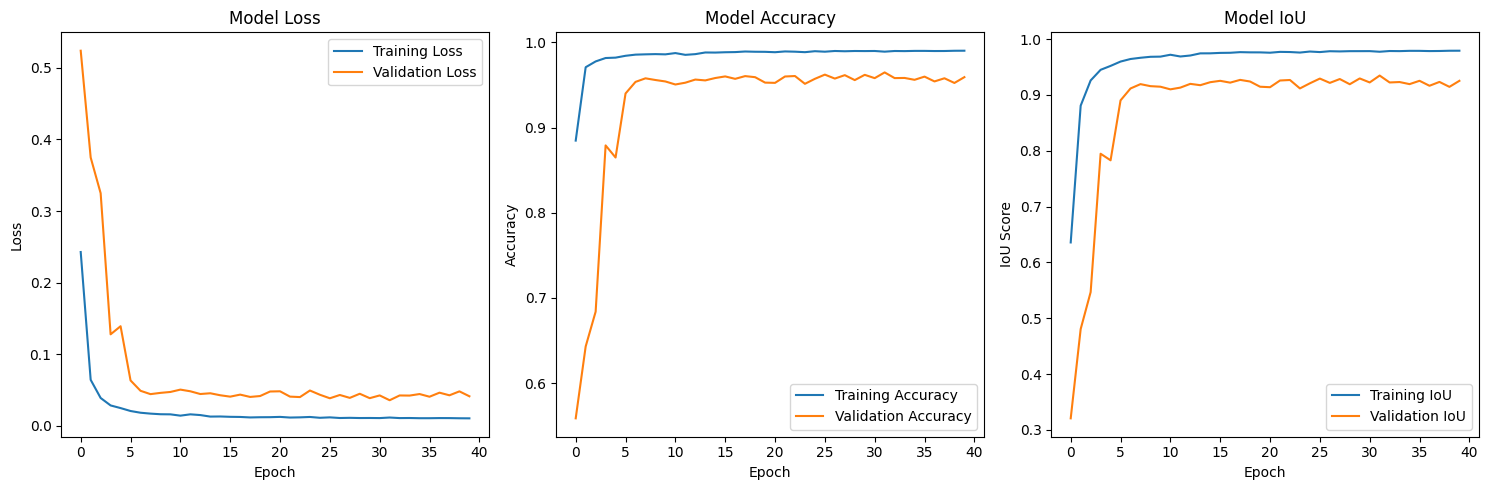

In [8]:
import numpy as np
import os
import cv2
from keras.utils import to_categorical
import segmentation_models as sm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Set parameters
seed = 24
batch_size = 16
n_classes = 4
IMG_HEIGHT = 256  # Target image height
IMG_WIDTH = 256  # Target image width
IMG_CHANNELS = 3  # Image channels (RGB)

# Preprocessing for ResNet34
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# File paths (from your existing code)
train_img_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\train\images"
train_mask_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\dataset\train\semantic_masks"
val_img_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\val\images"
val_mask_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\dataset\val\semantic_masks"

# Define the model using segmentation_models
def create_segmentation_model(backbone='resnet34', input_shape=(256, 256, 3), num_classes=4):
    """
    Create a semantic segmentation model using segmentation_models library
    """
    model = sm.Unet(
        backbone, 
        input_shape=input_shape, 
        classes=num_classes, 
        activation='softmax',
        encoder_weights='imagenet'  # Use pretrained ImageNet weights
    )
    
    return model

# Dice loss and metrics
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice coefficient for multi-class segmentation
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    
    return tf.reduce_mean((2. * intersection + smooth) / (union + smooth))

def dice_coef_loss(y_true, y_pred):
    """
    Dice loss function
    """
    return 1 - dice_coef(y_true, y_pred)

def iou_score(y_true, y_pred, smooth=1e-6):
    """
    Calculate Intersection over Union (IoU) for each class
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    
    return tf.reduce_mean((intersection + smooth) / (union + smooth))

# Create train and validation generators
train_img_gen = load_images_and_masks(train_img_path, train_mask_path, batch_size, n_classes)
val_img_gen = load_images_and_masks(val_img_path, val_mask_path, batch_size, n_classes)

# Count number of training and validation images
num_train_imgs = len(os.listdir(train_img_path))
num_val_imgs = len(os.listdir(val_img_path))

# Calculate steps per epoch
steps_per_epoch = num_train_imgs // batch_size
val_steps = num_val_imgs // batch_size

# Create model
model = create_segmentation_model(
    backbone=BACKBONE, 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 
    num_classes=n_classes
)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=[dice_coef_loss],  # You can also use 'categorical_crossentropy'
    metrics=[
        dice_coef,
        'accuracy',
        iou_score  # Add IoU score as a metric
    ]
)

# Print model summary
model.summary()

# Learning rate scheduler (optional)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    min_lr=1e-6
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=40,  # Increased epochs
    validation_data=val_img_gen,
    validation_steps=val_steps,
    callbacks=[lr_scheduler, early_stopping]
)

# Save the model
model.save(r'C:\Users\anart\OneDrive\Desktop\college\sem5\ML\finalmodel.h5')

# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# IoU plot
plt.subplot(1, 3, 3)
plt.plot(history.history['iou_score'], label='Training IoU')
plt.plot(history.history['val_iou_score'], label='Validation IoU')
plt.title('Model IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Debug: Unique values in predicted mask: [0 1 2]
Mapping details:
Old class 0 pixels before mapping: 27912
Old class 1 pixels before mapping: 29884
Old class 2 pixels before mapping: 7740
Mapping details after:
Class 0 pixels after mapping: 7740
Class 1 pixels after mapping: 27912
Class 2 pixels after mapping: 29884


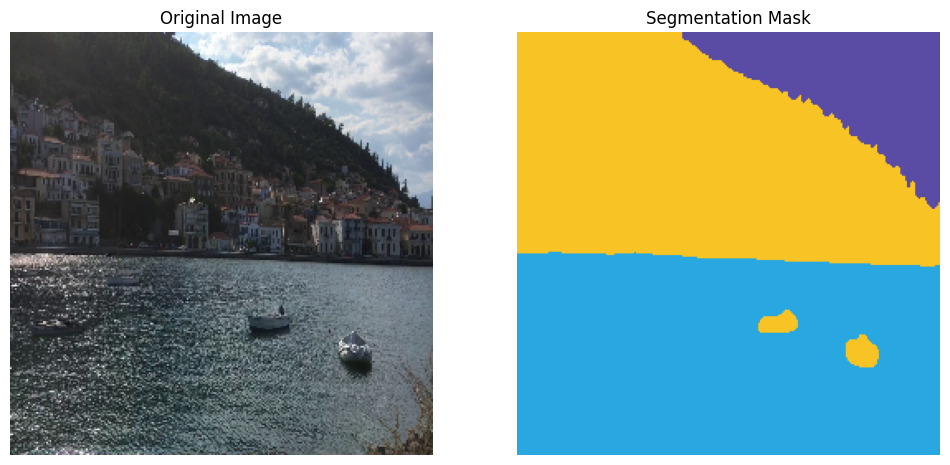

In [1]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define constants
IMG_WIDTH, IMG_HEIGHT = 256, 256  # Model input size

# Define class colors
CLASS_COLORS = {
    0: [164, 75, 90],     # Sky (Purple)
    2: [224, 167, 41],    # Water (Blue)
    1: [37, 195, 247]     # Obstacle (Yellow)
}

# Function to apply custom colors to the segmentation mask
def apply_class_colors(mask):
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Keep water and obstacle with their original colors
    colored_mask[mask == 1] = CLASS_COLORS[1]  # Water (Blue)
    colored_mask[mask == 2] = CLASS_COLORS[2]  # Obstacle (Yellow)

    # Any other class gets sky color
    colored_mask[~np.isin(mask, [1, 2])] = CLASS_COLORS[0]  # Sky (Purple)

    return colored_mask

# Debugging: Check predicted class indices
def debug_predicted_classes(pred_mask_class):
    unique_classes = np.unique(pred_mask_class)
    print(f"Debug: Unique values in predicted mask: {unique_classes}")

# Ensure the predicted mask uses the correct indices
def remap_classes(mask):
    mapping = {0: 1, 1: 2, 2: 0}
    print("Mapping details:")
    for old_class, new_class in mapping.items():
        print(f"Old class {old_class} pixels before mapping: {np.sum(mask == old_class)}")

    remapped_mask = np.zeros_like(mask)
    for old_class, new_class in mapping.items():
        remapped_mask[mask == old_class] = new_class

    print("Mapping details after:")
    for cls in range(3):
        print(f"Class {cls} pixels after mapping: {np.sum(remapped_mask == cls)}")

    return remapped_mask

# Function to process and display a single image
def process_and_display_image(image_path, model):
    # Read the image
    test_img = cv2.imread(image_path)
    if test_img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # Process image
    test_img_resized = cv2.resize(test_img, (IMG_WIDTH, IMG_HEIGHT))
    test_img_normalized = test_img_resized.astype('float32') / 255.0
    test_img_normalized = np.expand_dims(test_img_normalized, axis=0)

    # Get prediction
    pred_mask = model.predict(test_img_normalized)
    pred_mask_class = np.argmax(pred_mask, axis=-1)
    pred_mask_class = np.squeeze(pred_mask_class)

    # Debug and remap
    debug_predicted_classes(pred_mask_class)
    pred_mask_class = remap_classes(pred_mask_class)

    # Apply colors
    colored_mask = apply_class_colors(pred_mask_class)

    # Convert BGR to RGB for display
    test_img_rgb = cv2.cvtColor(test_img_resized, cv2.COLOR_BGR2RGB)
    colored_mask_rgb = cv2.cvtColor(colored_mask, cv2.COLOR_BGR2RGB)

    # Display results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(test_img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(colored_mask_rgb)
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Update with your paths
    image_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\test\images\inhouse_seq_347_00259.jpg"
    model_path = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\finalmodel.h5"

    # Load model
    model = load_model(model_path)

    # Process and display single image
    process_and_display_image(image_path, model)

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Define constants
IMG_WIDTH, IMG_HEIGHT = 256, 256  # Model input size

# Define class colors
CLASS_COLORS = {
    0: [164, 75, 90],     # Sky (Purple)
    2: [224, 167, 41],    # Water (Blue)
    1: [37, 195, 247]     # Obstacle (Yellow)
}

# Function to apply custom colors to the segmentation mask
def apply_class_colors(mask):
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Keep water and obstacle with their original colors
    colored_mask[mask == 1] = CLASS_COLORS[1]  # Water (Blue)
    colored_mask[mask == 2] = CLASS_COLORS[2]  # Obstacle (Yellow)

    # Any other class gets sky color
    colored_mask[~np.isin(mask, [1, 2])] = CLASS_COLORS[0]  # Sky (Purple)

    return colored_mask

# Debugging: Check predicted class indices
def debug_predicted_classes(pred_mask_class):
    unique_classes = np.unique(pred_mask_class)
    print(f"Debug: Unique values in predicted mask: {unique_classes}")

# Ensure the predicted mask uses the correct indices
def remap_classes(mask):
    mapping = {0: 1, 1: 2, 2: 0}
    print("Mapping details:")
    for old_class, new_class in mapping.items():
        print(f"Old class {old_class} pixels before mapping: {np.sum(mask == old_class)}")

    remapped_mask = np.zeros_like(mask)
    for old_class, new_class in mapping.items():
        remapped_mask[mask == old_class] = new_class

    print("Mapping details after:")
    for cls in range(3):
        print(f"Class {cls} pixels after mapping: {np.sum(remapped_mask == cls)}")

    return remapped_mask

# Function to process a single test image and save the mask as .png
def process_single_image(image_path, model, output_path):
    test_img = cv2.imread(image_path)
    if test_img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    test_img_resized = cv2.resize(test_img, (IMG_WIDTH, IMG_HEIGHT))
    test_img_normalized = test_img_resized.astype('float32') / 255.0
    test_img_normalized = np.expand_dims(test_img_normalized, axis=0)

    pred_mask = model.predict(test_img_normalized)

    pred_mask_class = np.argmax(pred_mask, axis=-1)
    pred_mask_class = np.squeeze(pred_mask_class)

    debug_predicted_classes(pred_mask_class)
    pred_mask_class = remap_classes(pred_mask_class)

    colored_mask = apply_class_colors(pred_mask_class)

    # Ensure the output is saved as .png
    if not output_path.endswith(".png"):
        output_path = os.path.splitext(output_path)[0] + ".png"

    cv2.imwrite(output_path, colored_mask)
    print(f"Colored mask saved to: {output_path}")

# Process all images in the input folder
def process_images_in_folder(input_folder, output_folder, model):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)
        if os.path.isfile(image_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + ".png")
            process_single_image(image_path, model, output_path)

# Example usage
if __name__ == "__main__":
    input_folder = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\semanticSegmentationTrial1\data\actualimages\test\images"  # Update with the input folder path
    output_folder = r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\xxxxxxxxxxx"  # Update with the output folder path

    # Load your trained model
    model = load_model(r"C:\Users\anart\OneDrive\Desktop\college\sem5\ML\finalmodel.h5")  # Update with your model path

    # Process all images in the input folder
    process_images_in_folder(input_folder, output_folder, model)

    print("Processing complete.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Debug: Unique values in predicted mask: [0 1 2]
Mapping details:
Old class 0 pixels before mapping: 19675
Old class 1 pixels before mapping: 31218
Old class 2 pixels before mapping: 14643
Mapping details after:
Class 0 pixels after mapping: 14643
Class 1 pixels after mapping: 19675
Class 2 pixels after mapping: 31218
Colored mask saved to: C:\Users\anart\OneDrive\Desktop\college\sem5\ML\xxxxxxxxxxx\davimar_seq_02_00040.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Debug: Unique values in predicted mask: [0 1 2]
Mapping details:
Old class 0 pixels before mapping: 19008
Old class 1 pixels before mapping: 32088
Old class 2 pixels before mapping: 14440
Mapping details after:
Class 0 pixels after mapping: 14440
Class 1 pixels after mapping: 19008
Class 2 pixels after mapping: 32088
Colored mask saved to: C:\Users\anart\OneDrive\Desktop\college\sem5\ML\xxxxxxxxxxx\davimar_seq_02_00102.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Debug: Unique values in predicte

KeyboardInterrupt: 